In [8]:
import logging
import cv2
import numpy as np
from scipy import integrate
from numpy.linalg import svd
import statistics
import os
from sklearn.decomposition import TruncatedSVD
# Create logger
log = logging.getLogger(__name__)
def compress_svd(image):
    U,s,V = svd(image,full_matrices=False)
    singularvalue = optht(image, s, sigma=None)
    reconst_matrix = np.dot(U[:,:singularvalue],np.dot(np.diag(s[:singularvalue]),V[:singularvalue,:]))
    return reconst_matrix,singularvalue
def optht(beta, sv, sigma=None):

    # Compute aspect ratio of the input matrix
    if isinstance(beta, np.ndarray):
        m = min(beta.shape)
        n = max(beta.shape)
        beta = m / n

    # Check ``beta``
    if beta < 0 or beta > 1:
        raise ValueError('Parameter `beta` must be in (0,1].')

    if sigma is None:
        # Sigma is unknown
        log.info('Sigma unknown.')
        # Approximate ``w(beta)``
        coef_approx = _optimal_SVHT_coef_sigma_unknown(beta)
        log.info(f'Approximated `w(beta)` value: {coef_approx}')
        # Compute the optimal ``w(beta)``
        coef = (_optimal_SVHT_coef_sigma_known(beta)
                / np.sqrt(_median_marcenko_pastur(beta)))
        # Compute cutoff
        cutoff = coef * np.median(sv)
    else:
        # Sigma is known
        log.info('Sigma known.')
        # Compute optimal ``w(beta)``
        coef = _optimal_SVHT_coef_sigma_known(beta)
        # Compute cutoff
        cutoff = coef * np.sqrt(len(sv)) * sigma
    # Log cutoff and ``w(beta)``
    log.info(f'`w(beta)` value: {coef}')
    log.info(f'Cutoff value: {cutoff}')
    # Compute and return rank
    greater_than_cutoff = np.where(sv > cutoff)
    if greater_than_cutoff[0].size > 0:
        k = np.max(greater_than_cutoff) + 1
    else:
        k = 0
    log.info(f'Target rank: {k}')
    return k


def _optimal_SVHT_coef_sigma_known(beta):
    """Implement Equation (11)."""
    return np.sqrt(2 * (beta + 1) + (8 * beta)
                   / (beta + 1 + np.sqrt(beta**2 + 14 * beta + 1)))


def _optimal_SVHT_coef_sigma_unknown(beta):
    """Implement Equation (5)."""
    return 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43
def _mar_pas(x, topSpec, botSpec, beta):
    """Implement Marcenko-Pastur distribution."""
    if (topSpec - x) * (x - botSpec) > 0:
        return np.sqrt((topSpec - x) *
                       (x - botSpec)) / (beta * x) / (2 * np.pi)
    else:
        return 0


def _median_marcenko_pastur(beta):
    """Compute median of Marcenko-Pastur distribution."""
    botSpec = lobnd = (1 - np.sqrt(beta))**2
    topSpec = hibnd = (1 + np.sqrt(beta))**2
    change = 1

    while change & ((hibnd - lobnd) > .001):
        change = 0
        x = np.linspace(lobnd, hibnd, 10)
        y = np.zeros_like(x)
        for i in range(len(x)):
            yi, err = integrate.quad(
                _mar_pas,
                a=x[i],
                b=topSpec,
                args=(topSpec, botSpec, beta),
            )
            y[i] = 1.0 - yi

        if np.any(y < 0.5):
            lobnd = np.max(x[y < 0.5])
            change = 1

        if np.any(y > 0.5):
            hibnd = np.min(x[y > 0.5])
            change = 1

    return (hibnd + lobnd) / 2.


In [9]:
def compress_show_color_images_layer(img_name):
    global kvalue

    global compression_ratio
    image = img_name
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_shape = image.shape
    print(original_shape)
    image_reconst_layers = []
    kmean = []
    for i in range(3):
        
        x,y = compress_svd(image[:,:,i])
        print(x.shape)
        image_reconst_layers.append(x)
        kmean.append(y)  
    kvalue = statistics.mean(kmean)        
    
    image_reconst = np.zeros(image.shape)
    for i in range(3):
        image_reconst[:,:,i] = image_reconst_layers[i]
    
    compression_ratio =100.0*3* (kvalue*(original_shape[0] + original_shape[1])+kvalue)/(original_shape[0]*original_shape[1]*original_shape[2])
    return image_reconst

def compress_show_color_images_reshape(img_name):
    global kvalue
    global compression_ratio
    image = img_name
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_shape = image.shape
    image_reshaped = image.reshape((original_shape[0],original_shape[1]*3))
    image_reconst,kvalue = compress_svd(image_reshaped)
    image_reconst = image_reconst.reshape(original_shape)
    compression_ratio =100.0* (kvalue*(original_shape[0] + 3*original_shape[1])+kvalue)/(original_shape[0]*original_shape[1]*original_shape[2])

    return image_reconst

In [10]:
import os
import sys
import csv
import cv2
from PIL import Image
input_dir = 'test'
output_dir = 'output1'
from csv import DictWriter
  
# list of column names 
  
# Dictionary
alldatadetails = []
def compressMe(file, verbose = False):
	
	# Get the path of the file
	filepath = os.path.join(input_dir,
							file)
	
	# open the image
	im = cv2.imread(filepath)
	picture = compress_show_color_images_layer(im)

	picture = Image.fromarray(np.uint8(picture))
	picture.save(f"{output_dir}\Compressed_"+file,
				"JPEG")
	file_sizebefore = os.path.getsize(f'{input_dir}/{file}')
	file_sizeafter = os.path.getsize(f'{output_dir}/Compressed_{file}')    
	width = im.shape[1]
	height = im.shape[0]
	channel = im.shape[2]
    
	theoritical_imagesize = width*height*channel
	theoritical_compressedsize = 3* (kvalue*(width + height)+kvalue)
	practically_compression_percent = 100*(file_sizeafter/file_sizebefore)
	practical_theoritical_size_percent = file_sizebefore/theoritical_imagesize
	compressed_practical_theoritical_size_percent = file_sizeafter/theoritical_compressedsize
	data = [file,height,width,channel,kvalue,file_sizebefore,file_sizeafter,theoritical_imagesize,theoritical_compressedsize,practical_theoritical_size_percent,compressed_practical_theoritical_size_percent,compression_ratio,practically_compression_percent]
	print(data)
	alldatadetails.append(data)
         
	#print(f"{file},{im.shape[0]},{im.shape[1]},{im.shape[2]},{kvalue},{compression_ratio},{file_sizebefore},{file_sizeafter}")
	return

# Define a main function
def main():
	
	verbose = False
	
	# checks for verbose flag
	if (len(sys.argv)>1):
		
		if (sys.argv[1].lower()=="-v"):
			verbose = True
					
	# finds current working dir
	inputpath = input_dir

	formats = ('.jpg', '.jpeg')
	
	# looping through all the files
	# in a current directory
	for file in os.listdir(inputpath):
		
		# If the file format is JPG or JPEG
		if os.path.splitext(file)[1].lower() in formats:
			compressMe(file, verbose)
     
	Details = ['filename','height','width','channel','singularmatrixn','practical_image_size','practical_compressed_image_size','therotical_size','theortical_compressionsize','practicallysize/therotical_size','practicallcompress_size/theortical_compressionsize','theoritcal_compressionratio','practically_compression_percent']
 
    
	with open('imagecompressiondata.csv', 'w') as f: 
		write = csv.writer(f) 
		write.writerow(Details) 
		write.writerows(alldatadetails)
		f.close()
            


	

# Driver code
if __name__ == "__main__":
	main()


(694, 1330, 3)
(694, 1330)
(694, 1330)
(694, 1330)
['climate.jpg', 694, 1330, 3, 191, 159281, 189111, 2769060, 1160325, 0.057521686059529224, 0.1629810613405727, 41.90320903122359, 118.72790853899713]
(865, 1000, 3)
(865, 1000)
(865, 1000)
(865, 1000)
['test.jpg', 865, 1000, 3, 242, 267993, 122723, 2595000, 1354716, 0.1032728323699422, 0.09058946672217645, 52.20485549132948, 45.79336027433553]
(48, 48, 3)
(48, 48)
(48, 48)
(48, 48)
['Training_3908.jpg', 48, 48, 3, 11, 2536, 1484, 6912, 3201, 0.36689814814814814, 0.46360512339893784, 46.310763888888886, 58.51735015772871]


In [17]:
import pandas as pd
df = pd.read_csv('imagecompressiondataANTIALIAS.csv')

In [18]:
df

,filename,height,width,channel,singularmatrixn,practical_image_size,practical_compressed_image_size,therotical_size,theortical_compressionsize,practicallysize/therotical_size,practicallcompress_size/theortical_compressionsize,theoritcal_compressionratio,practically_compression_percent
0,50+ HD Backgrounds Pack By Deepak Creations (1...,2377,3166,3,0,2556819,1504164,22576746,0,0,0,0,58.829507
1,50+ HD Backgrounds Pack By Deepak Creations (1...,3992,5988,3,0,3691267,2616582,71712288,0,0,0,0,70.885742
2,50+ HD Backgrounds Pack By Deepak Creations (1...,3549,5324,3,0,3690856,2398062,56684628,0,0,0,0,64.973058
3,50+ HD Backgrounds Pack By Deepak Creations (1...,3355,5032,3,0,3641465,2681965,50647080,0,0,0,0,73.650715
4,50+ HD Backgrounds Pack By Deepak Creations (1...,3898,5839,3,0,3527209,2652985,68281266,0,0,0,0,75.214851
5,50+ HD Backgrounds Pack By Deepak Creations (1...,4000,6000,3,0,3495841,2567861,72000000,0,0,0,0,73.454742
6,50+ HD Backgrounds Pack By Deepak Creations (1...,3456,5184,3,0,3399143,2547650,53747712,0,0,0,0,74.949774
7,50+ HD Backgrounds Pack By Deepak Creations (1...,4480,6720,3,0,3337046,2159333,90316800,0,0,0,0,64.707918
8,50+ HD Backgrounds Pack By Deepak Creations (1...,3413,4551,3,0,3161500,1890109,46597689,0,0,0,0,59.785197
9,50+ HD Backgrounds Pack By Deepak Creations (1...,4000,6000,3,0,3127600,2410847,72000000,0,0,0,0,77.082971


In [ ]:
#theoritical size = Widhth*HEight
#theoritical compression = width*singularmatrixn + singularmatrixn + height*singularmatrixn

In [25]:
# MODELING
import pandas as pd # data processing
import numpy as np # working with arrays
import matplotlib.pyplot as plt # visualization
import seaborn as sb # visualization
from termcolor import colored as cl # text customization
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression # OLS algorithm
from sklearn.linear_model import Ridge # Ridge algorithm
from sklearn.linear_model import Lasso # Lasso algorithm
from sklearn.linear_model import BayesianRidge # Bayesian algorithm
from sklearn.linear_model import ElasticNet # ElasticNet algorithm
from statistics import mean
from sklearn.metrics import explained_variance_score as evs # evaluation metric
from sklearn.metrics import r2_score as r2 # evaluation metric
from sklearn.model_selection import train_test_split # data split
# 1. OLS
X = df[['practical_image_size','therotical_size']].values
y = df['practical_compressed_image_size'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 50)
cv = 5
ols = LinearRegression()
scores = cross_val_score(ols, X, y, cv=cv)
print(mean(scores))

# 2. Ridge

ridge = Ridge(alpha = 0.5)
scores = cross_val_score(ridge, X, y, cv=cv)
print(mean(scores))

# 3. Lasso

lasso = Lasso(alpha = 0.01)
scores = cross_val_score(lasso, X, y, cv=cv)
print(mean(scores))

# 4. Bayesian

bayesian = BayesianRidge()
scores = cross_val_score(bayesian, X, y, cv=cv)
print(mean(scores))

# 5. ElasticNet

en = ElasticNet(alpha = 0.01)
scores = cross_val_score(en, X, y, cv=cv)
print(mean(scores))

'''


print(cl('EXPLAINED VARIANCE SCORE:', attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('Explained Variance Score of OLS model is {}'.format(evs(y_test, ols_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('Explained Variance Score of Ridge model is {}'.format(evs(y_test, ridge_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('Explained Variance Score of Lasso model is {}'.format(evs(y_test, lasso_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('Explained Variance Score of Bayesian model is {}'.format(evs(y_test, bayesian_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('Explained Variance Score of ElasticNet is {}'.format(evs(y_test, en_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

# 2. R-squared

print(cl('R-SQUARED:', attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('R-Squared of OLS model is {}'.format(r2(y_test, ols_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('R-Squared of Ridge model is {}'.format(r2(y_test, ridge_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('R-Squared of Lasso model is {}'.format(r2(y_test, lasso_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('R-Squared of Bayesian model is {}'.format(r2(y_test, bayesian_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('R-Squared of ElasticNet is {}'.format(r2(y_test, en_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')'''

0.6426862635255461
0.6426862635255458
0.6426862635255411
0.6286552045055676
0.6426862635255441


"\n\n\nprint(cl('EXPLAINED VARIANCE SCORE:', attrs = ['bold']))\n\nprint('-------------------------------------------------------------------------------')\n\nprint(cl('Explained Variance Score of OLS model is {}'.format(evs(y_test, ols_yhat)), attrs = ['bold']))\n\nprint('-------------------------------------------------------------------------------')\n\nprint(cl('Explained Variance Score of Ridge model is {}'.format(evs(y_test, ridge_yhat)), attrs = ['bold']))\n\nprint('-------------------------------------------------------------------------------')\n\nprint(cl('Explained Variance Score of Lasso model is {}'.format(evs(y_test, lasso_yhat)), attrs = ['bold']))\n\nprint('-------------------------------------------------------------------------------')\n\nprint(cl('Explained Variance Score of Bayesian model is {}'.format(evs(y_test, bayesian_yhat)), attrs = ['bold']))\n\nprint('-------------------------------------------------------------------------------')\n\nprint(cl('Explained Var

In [4]:
image

NameError: name 'image' is not defined

In [33]:

x = Image.open('50+ HD Backgrounds Pack By Deepak Creations (3).jpg')
channels=np.asarray(x)


In [19]:
getType(x)

NameError: name 'getType' is not defined

(865, 1000, 3)

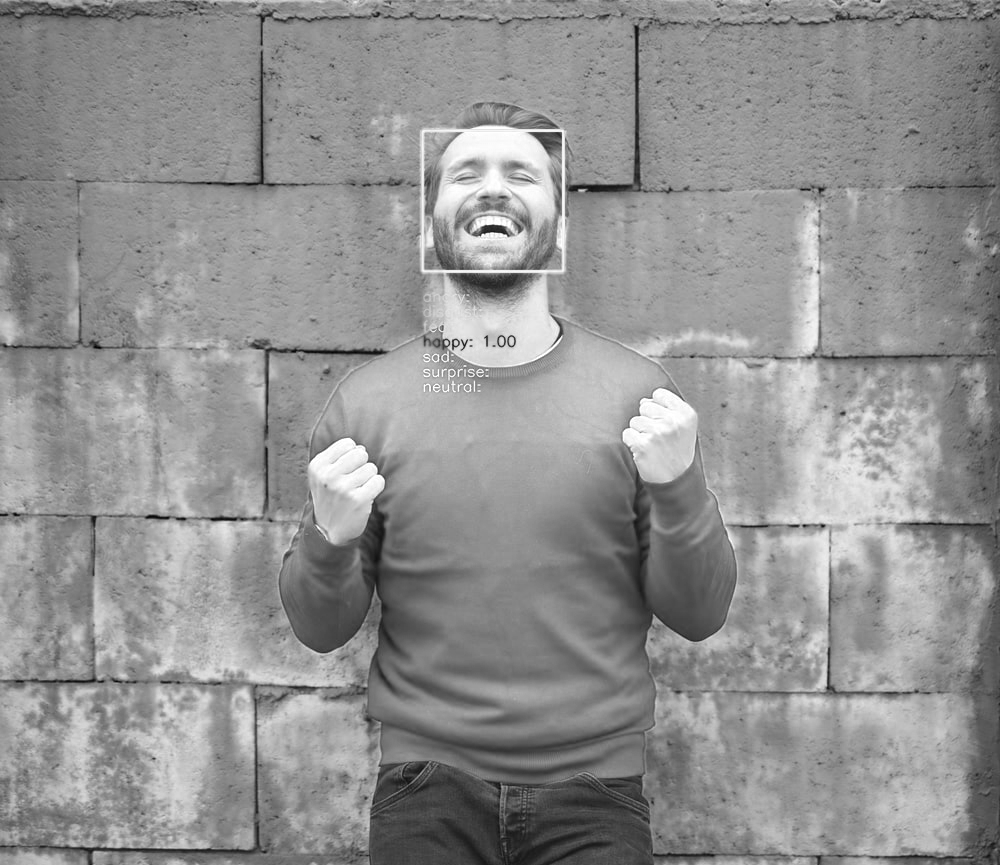

In [26]:
Image.fromarray(channels[:,:,2])

In [ ]:
import cv2

image = cv2.imread('test.jpg')

b = image.copy()
# set green and red channels to 0
b[:, :, 1] = 0
b[:, :, 2] = 0


g = image.copy()
# set blue and red channels to 0
g[:, :, 0] = 0
g[:, :, 2] = 0

r = image.copy()
# set blue and green channels to 0
r[:, :, 0] = 0
r[:, :, 1] = 0


# RGB - Blue
cv2.imshow('B-RGB', b)

# RGB - Green
cv2.imshow('G-RGB', g)

# RGB - Red
cv2.imshow('R-RGB', r)

cv2.waitKey(0)

In [51]:
im1 = x.resize((int(channels.shape[1]/100),int(channels.shape[0]/100)))
im1.save(f"{output_dir}\Compressedbyreize.jpg")

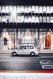

In [52]:
im1

In [36]:
channels.shape

(7952, 5304, 3)

In [37]:
((int(channels.shape[0]/2),int(channels.shape[1]/2)))

(3976, 2652)

In [38]:
ch = np.asarray(im1)
ch.shape

(2652, 3976, 3)

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys


def display_image(arg_img):
    """method to display the image"""
    cv2.imshow('image', arg_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


def im2double(im):
    """method to get double precision of a channel"""
    info = np.iinfo(im.dtype) # Get the data type of the input image
    return im.astype(np.float) / info.max


def channel_svd(channel):
    """
    method to calculate svd of the input data matrix
    :param channel: data matrix whose svd is to be calculatec
    :return: list of three matrices: U, Sigma and V transpose
    """
    [u, sigma, vt] = np.linalg.svd(channel)
    return [u, sigma, vt]


def calculate_frobenius_norm(channel, u, s_diagonalized, vt):
    """
    method to calculate the frobenius norm of the reconstructed matrix
    Done by taking 1 to k (k=rank of the channel) components in the reconstruction process.
    :return: list of frobenius norms calculated by the first k signular values of the matrix
    """
    rank_channel = np.linalg.matrix_rank(channel)
    frobenius_norm_array = np.zeros(rank_channel)
    for k in range(1, rank_channel+1):
        u_k = u[:, :k]
        s_diagonalized_k = s_diagonalized[:k, :k]
        vt_k = vt[:k, :]
        channel_reconstruction_matrix = np.dot(np.dot(u_k, s_diagonalized_k), vt_k)
        rec_error_matrix = np.subtract(channel, channel_reconstruction_matrix)
        frobenius_norm = np.linalg.norm(rec_error_matrix, 'fro')
        frobenius_norm_array[k-1] = frobenius_norm
    return frobenius_norm_array


def calculate_optimal_k(singular_values, rank):
    """method to calculate the optimal k"""
    heuristic_k = 0.15 * rank
    optimal_k = heuristic_k
    end_idx = len(singular_values) - 10
    for idx in range(0, end_idx):
        sig_diff = max(singular_values[idx:idx + 10]) - min(singular_values[idx:idx + 10])
        if sig_diff < 0.32:
            optimal_k = idx
            break
    return min(heuristic_k, optimal_k)


def channel_via_optimal_k(k, u, s_diagonalized, vt):
    """reconstructs a matrix by selecting optimal_k signular values"""
    channel_u_k = u[:, :k]
    channel_s_diagonal_k = s_diagonalized[:k, :k]
    channel_vt_k = vt[:k, :]
    channel_reconstruction_matrix = np.dot(np.dot(channel_u_k, channel_s_diagonal_k), channel_vt_k)
    channel_reconstruction_matrix = 255 * channel_reconstruction_matrix
    return channel_reconstruction_matrix


def plot_singular_values(s_red, s_blue, s_green):
    """Plot the singular values of the three channels on loglog graph for analysis"""
    non_zero_s_red = s_red[np.nonzero(s_red)]
    non_zero_s_blue = s_blue[np.nonzero(s_blue)]
    non_zero_s_green = s_green[np.nonzero(s_green)]
    x = np.linspace(0, 1, len(non_zero_s_red))
    plt.loglog(x, non_zero_s_red, 'r')
    plt.loglog(x, non_zero_s_blue, 'b')
    plt.loglog(x, non_zero_s_green, 'g')
    plt.ylabel('Singular values of the three channels.')
    plt.show()


def plot_frobenius_norm(red_frobenius_norm, blue_frobenius_norm, green_frobenius_norm, rank_channel):
    """Plot the frobenius norm of the three channels on for analysis"""
    x = np.arange(1, rank_channel+1)
    plt.xlabel('k')
    plt.ylabel('Frobenius norm')
    plt.plot(x, red_frobenius_norm, 'r', x, blue_frobenius_norm, 'b', x, green_frobenius_norm, 'g')
    plt.show()


def percentage_of_info_restored(k, all_singular_values):
    """calculate percentage of information restored. Measured as sum of singular values
    retained in the optimal_k dimensions divided by total sum of singular values."""
    sum_sigma = 0
    sum_k_sigma = 0
    for sigma_matrix in all_singular_values:
        sum_sigma += np.trace(sigma_matrix)
    for sigma_matrix in all_singular_values:
        stripped_sigma_matrix = sigma_matrix[:k, :k]
        sum_k_sigma += np.trace(stripped_sigma_matrix)
    return (sum_k_sigma/sum_sigma)*100


img = cv2.imread('wallpaper/50+ HD Backgrounds Pack By Deepak Creations (1).jpg')
print(img)
blue_channel = im2double(img[:, :, 0])
green_channel = im2double(img[:, :, 1])
red_channel = im2double(img[:, :, 2])

[u_red, s_red, vt_red] = channel_svd(red_channel)
[u_blue, s_blue, vt_blue] = channel_svd(blue_channel)
[u_green, s_green, vt_green] = channel_svd(green_channel)

rank_channel = np.linalg.matrix_rank(red_channel)

#plot_singular_values(s_red, s_blue, s_green)

optimal_k_red = calculate_optimal_k(s_red, rank_channel)
optimal_k_blue = calculate_optimal_k(s_blue, rank_channel)
optimal_k_green = calculate_optimal_k(s_green, rank_channel)
optimal_k = int(np.median(np.asarray([optimal_k_red, optimal_k_blue, optimal_k_green])))

s_red_diagonalize = np.diag(s_red)
s_blue_diagonalize = np.diag(s_blue)
s_green_diagonalize = np.diag(s_green)
per_info = percentage_of_info_restored(optimal_k,
                                       [s_red_diagonalize, s_blue_diagonalize, s_green_diagonalize])

print( "Number of dimensions in the image:", rank_channel)
print ("Number of dimensions used in reconstruction:", optimal_k)
print ("Percentage of information restored:", per_info)

red_frobenius_norm = calculate_frobenius_norm(red_channel, u_red, s_red_diagonalize, vt_red)
blue_frobenius_norm = calculate_frobenius_norm(blue_channel, u_blue, s_blue_diagonalize, vt_blue)
green_frobenius_norm = calculate_frobenius_norm(green_channel, u_green, s_green_diagonalize, vt_green)

#plot_frobenius_norm(red_frobenius_norm, blue_frobenius_norm, green_frobenius_norm, rank_channel)

print( "Frobenius Norm of Red channel:", red_frobenius_norm[optimal_k])
print( "Frobenius Norm of Blue channel:", blue_frobenius_norm[optimal_k])
print( "Frobenius Norm of Green channel:", green_frobenius_norm[optimal_k])

blue_reconstruction_matrix = channel_via_optimal_k(optimal_k, u_blue, s_blue_diagonalize, vt_blue)
green_reconstruction_matrix = channel_via_optimal_k(optimal_k, u_green, s_green_diagonalize, vt_green)
red_reconstruction_matrix = channel_via_optimal_k(optimal_k, u_red, s_red_diagonalize, vt_red)

re_image = cv2.merge((blue_reconstruction_matrix, green_reconstruction_matrix, red_reconstruction_matrix))
cv2.imwrite('restored_image.jpg', re_image)

[[[ 4  5  3]
  [ 3  4  2]
  [ 2  3  1]
  ...
  [ 2  2  2]
  [ 4  4  4]
  [ 3  4  2]]

 [[ 2  3  1]
  [ 2  3  1]
  [ 2  3  1]
  ...
  [ 9  9  9]
  [ 6  7  5]
  [ 5  6  4]]

 [[ 1  2  0]
  [ 3  4  2]
  [ 4  5  3]
  ...
  [ 9 10  8]
  [ 5  6  4]
  [ 5  6  4]]

 ...

 [[18 19 15]
  [ 5  6  2]
  [ 6  8  2]
  ...
  [ 7  8  4]
  [11 12  8]
  [ 8  9  5]]

 [[ 8 10  4]
  [ 1  3  0]
  [ 4  6  0]
  ...
  [ 3  4  2]
  [ 5  6  4]
  [ 3  4  2]]

 [[ 5  7  1]
  [ 2  4  0]
  [ 3  5  0]
  ...
  [ 3  4  2]
  [ 5  6  4]
  [ 5  6  4]]]
Number of dimensions in the image: 2377
Number of dimensions used in reconstruction: 81
Percentage of information restored: 32.61565768055441


KeyboardInterrupt: 

In [16]:
import os
import sys
import csv
from PIL import Image
input_dir = 'wallpaper'
output_dir = 'outputantialias'
from csv import DictWriter
  
# list of column names 
  
# Dictionary
alldatadetails = []
def compressMe(file, verbose = False):
	
	# Get the path of the file
	filepath = os.path.join(input_dir,
							file)
	ima = Image.open(filepath)
	H,W = ima.size
	picture = ima.resize((H,W),Image.ANTIALIAS)
	picture.save(f"{output_dir}\Compressed_"+file,
				"JPEG",optimize = True)
	file_sizebefore = os.path.getsize(f'{input_dir}/{file}')
	file_sizeafter = os.path.getsize(f'{output_dir}/Compressed_{file}')    
	width = W
	height = H
	channel = 3
    
	theoritical_imagesize = W*H*3
	theoritical_compressedsize = 0
	practically_compression_percent = 100*(file_sizeafter/file_sizebefore)
	practical_theoritical_size_percent =0
	compressed_practical_theoritical_size_percent = 0
	data = [file,height,width,channel,0,file_sizebefore,file_sizeafter,theoritical_imagesize,theoritical_compressedsize,practical_theoritical_size_percent,compressed_practical_theoritical_size_percent,0,practically_compression_percent]
	print(data)
	alldatadetails.append(data)
         
	#print(f"{file},{im.shape[0]},{im.shape[1]},{im.shape[2]},{kvalue},{compression_ratio},{file_sizebefore},{file_sizeafter}")
	return

# Define a main function
def main():
	
	verbose = False
	
	# checks for verbose flag
	if (len(sys.argv)>1):
		
		if (sys.argv[1].lower()=="-v"):
			verbose = True
					
	# finds current working dir
	inputpath = input_dir

	formats = ('.jpg', '.jpeg')
	
	# looping through all the files
	# in a current directory
	for file in os.listdir(inputpath):
		
		# If the file format is JPG or JPEG
		if os.path.splitext(file)[1].lower() in formats:
			compressMe(file, verbose)
     
	Details = ['filename','height','width','channel','singularmatrixn','practical_image_size','practical_compressed_image_size','therotical_size','theortical_compressionsize','practicallysize/therotical_size','practicallcompress_size/theortical_compressionsize','theoritcal_compressionratio','practically_compression_percent']
 
    
	with open('imagecompressiondataANTIALIAS.csv', 'w') as f: 
		write = csv.writer(f) 
		write.writerow(Details) 
		write.writerows(alldatadetails)
		f.close()
            


	

# Driver code
if __name__ == "__main__":
	main()


['50+ HD Backgrounds Pack By Deepak Creations (1).jpg', 2377, 3166, 3, 0, 2556819, 1504164, 22576746, 0, 0, 0, 0, 58.82950650789125]
['50+ HD Backgrounds Pack By Deepak Creations (10).jpg', 3992, 5988, 3, 0, 3691267, 2616582, 71712288, 0, 0, 0, 0, 70.88574194172354]
['50+ HD Backgrounds Pack By Deepak Creations (11).jpg', 3549, 5324, 3, 0, 3690856, 2398062, 56684628, 0, 0, 0, 0, 64.97305774053498]
['50+ HD Backgrounds Pack By Deepak Creations (12).jpg', 3355, 5032, 3, 0, 3641465, 2681965, 50647080, 0, 0, 0, 0, 73.65071475354013]
['50+ HD Backgrounds Pack By Deepak Creations (13).jpg', 3898, 5839, 3, 0, 3527209, 2652985, 68281266, 0, 0, 0, 0, 75.21485117553284]
['50+ HD Backgrounds Pack By Deepak Creations (14).jpg', 4000, 6000, 3, 0, 3495841, 2567861, 72000000, 0, 0, 0, 0, 73.45474236385465]
['50+ HD Backgrounds Pack By Deepak Creations (15).jpg', 3456, 5184, 3, 0, 3399143, 2547650, 53747712, 0, 0, 0, 0, 74.94977410482583]
['50+ HD Backgrounds Pack By Deepak Creations (16).jpg', 4480, 